## Mount Colab to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
path1 = "/content/drive/My Drive/DAT 490/Datafiles/Crashes.csv"
path2 = "/content/drive/My Drive/DAT 490/Datafiles/People.csv"
path3 = "/content/drive/My Drive/DAT 490/Datafiles/Vehicles.csv"

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

## Load Data Sets

In [4]:
Crashes = pd.read_csv(path1)
People = pd.read_csv(path2)
Vehicles = pd.read_csv(path3)

# Graphs

## Distribution of Injuries

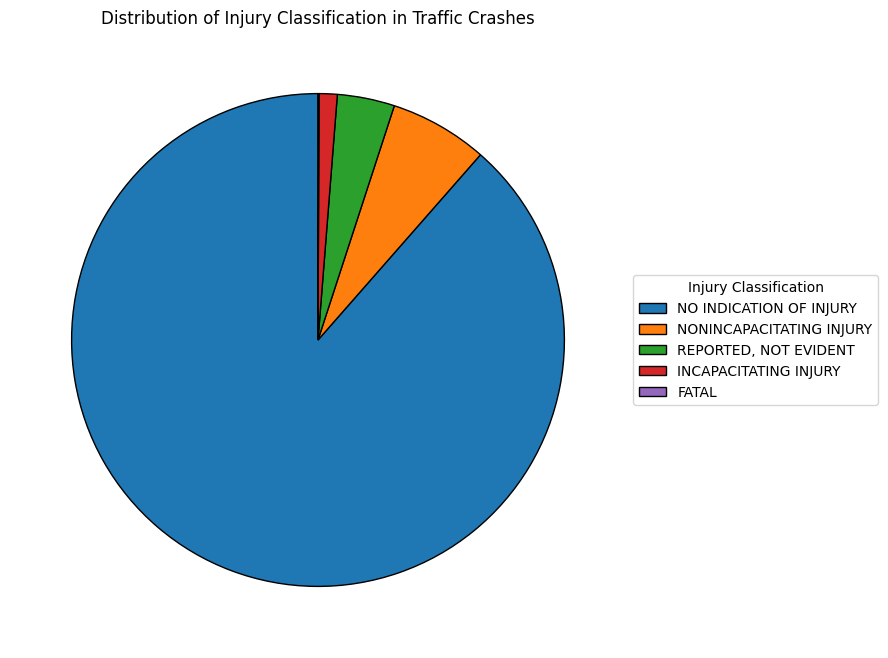

In [14]:
# Counts for different injuries
injury_distribution = People['INJURY_CLASSIFICATION'].value_counts()

# Pie Chart
plt.figure(figsize=(8, 8))
wedges, texts = plt.pie(injury_distribution, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.legend(wedges, injury_distribution.index, title="Injury Classification", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('Distribution of Injury Classification in Traffic Crashes')
plt.ylabel('')
plt.show()

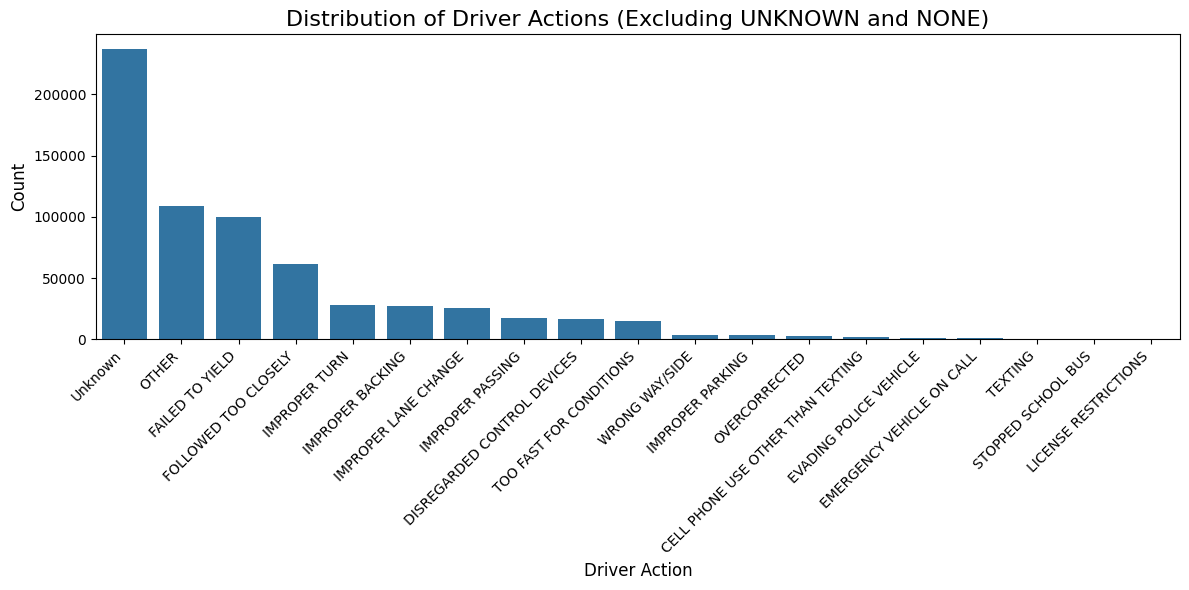

In [17]:
# Filter out 'UNKNOWN' and 'NONE'
filtered_people = People[(People['DRIVER_ACTION'] != 'UNKNOWN') & (People['DRIVER_ACTION'] != 'NONE')]

plt.figure(figsize=(12, 6))

# Counts of driver actions
sns.countplot(data=filtered_people, x='DRIVER_ACTION', order=filtered_people['DRIVER_ACTION'].value_counts().index)


plt.title('Distribution of Driver Actions (Excluding UNKNOWN and NONE)', fontsize=16)
plt.xlabel('Driver Action', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
# datetime format
People['CRASH_DATE'] = pd.to_datetime(People['CRASH_DATE'])

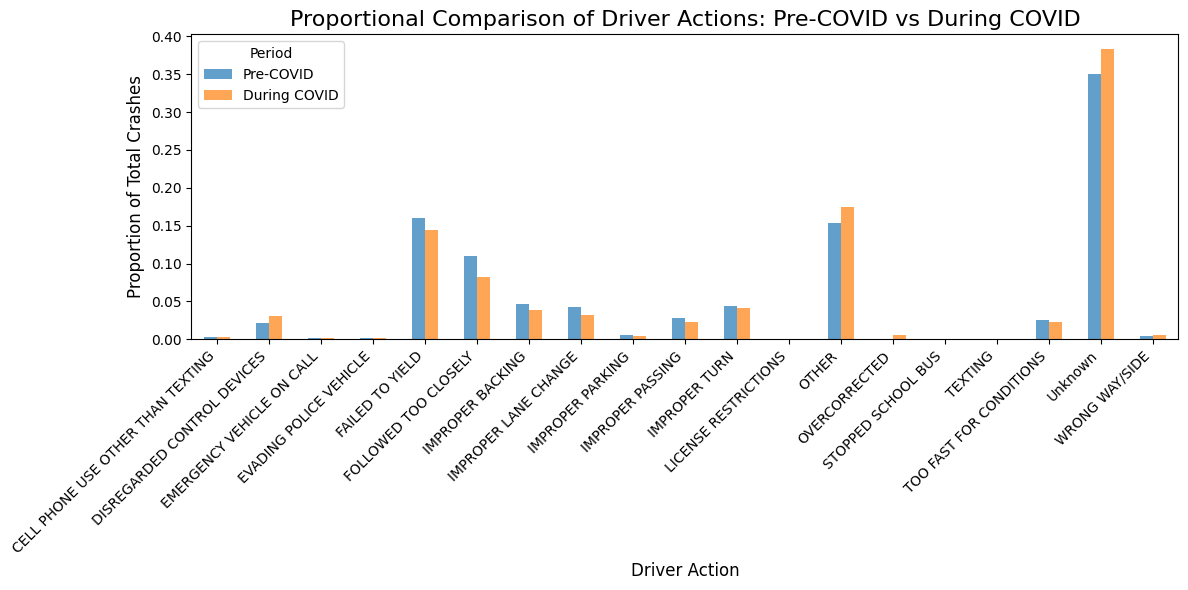

In [19]:
# COVID dates
covid_start_date = pd.to_datetime('2020-03-01')
covid_end_date = pd.to_datetime('2021-12-31')

# pre-COVID and during-COVID dates
pre_covid_data = People[People['CRASH_DATE'] < covid_start_date]
covid_data = People[(People['CRASH_DATE'] >= covid_start_date) & (People['CRASH_DATE'] <= covid_end_date)]

# Filter 'UNKNOWN' and 'NONE' from DRIVER_ACTION
pre_covid_data = pre_covid_data[(pre_covid_data['DRIVER_ACTION'] != 'UNKNOWN') & (pre_covid_data['DRIVER_ACTION'] != 'NONE')]
covid_data = covid_data[(covid_data['DRIVER_ACTION'] != 'UNKNOWN') & (covid_data['DRIVER_ACTION'] != 'NONE')]

# Count of crashes in each period
total_pre_covid_crashes = pre_covid_data.shape[0]
total_covid_crashes = covid_data.shape[0]

# Group and counts
pre_covid_driver_action = pre_covid_data['DRIVER_ACTION'].value_counts()
covid_driver_action = covid_data['DRIVER_ACTION'].value_counts()

# Proportion for each period
pre_covid_proportion = pre_covid_driver_action / total_pre_covid_crashes
covid_proportion = covid_driver_action / total_covid_crashes

# Dataframe with proportions
driver_action_proportions = pd.DataFrame({
    'Pre-COVID': pre_covid_proportion,
    'During COVID': covid_proportion
}).fillna(0)

# Plot bar graph
driver_action_proportions.plot(kind='bar', figsize=(12, 6), alpha=0.7)
plt.title('Proportional Comparison of Driver Actions: Pre-COVID vs During COVID', fontsize=16)
plt.xlabel('Driver Action', fontsize=12)
plt.ylabel('Proportion of Total Crashes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Period')
plt.tight_layout()
plt.show()

## Monthly Crash Trends (2018 and later)

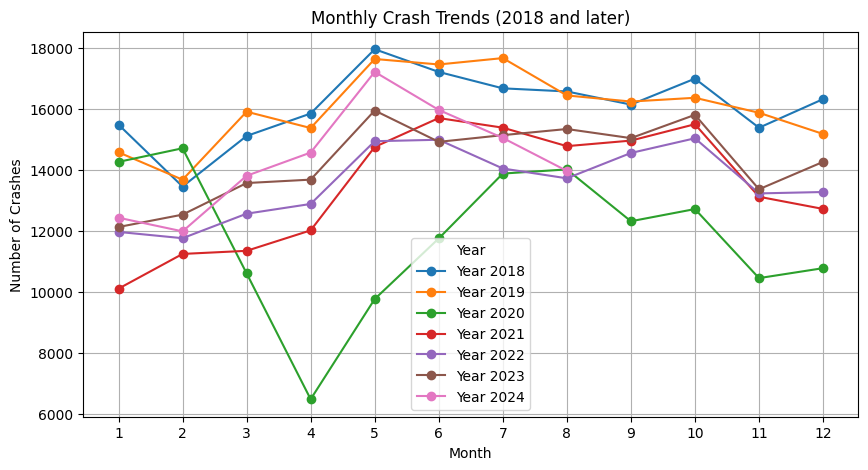

In [7]:
# Covid period
covid_period_data = People[People['CRASH_YEAR'] >= 2018]

# Group data by year and month
monthly_trends = covid_period_data.groupby(['CRASH_YEAR', 'CRASH_MONTH']).size().reset_index(name='Crash_Count')


plt.figure(figsize=(10, 5))

# For each year
for year in monthly_trends['CRASH_YEAR'].unique():
    year_data = monthly_trends[monthly_trends['CRASH_YEAR'] == year]
    plt.plot(year_data['CRASH_MONTH'], year_data['Crash_Count'], marker='o', label=f'Year {year}')

plt.title('Monthly Crash Trends (2018 and later)')
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.grid(True)
plt.show()

## BAC Results

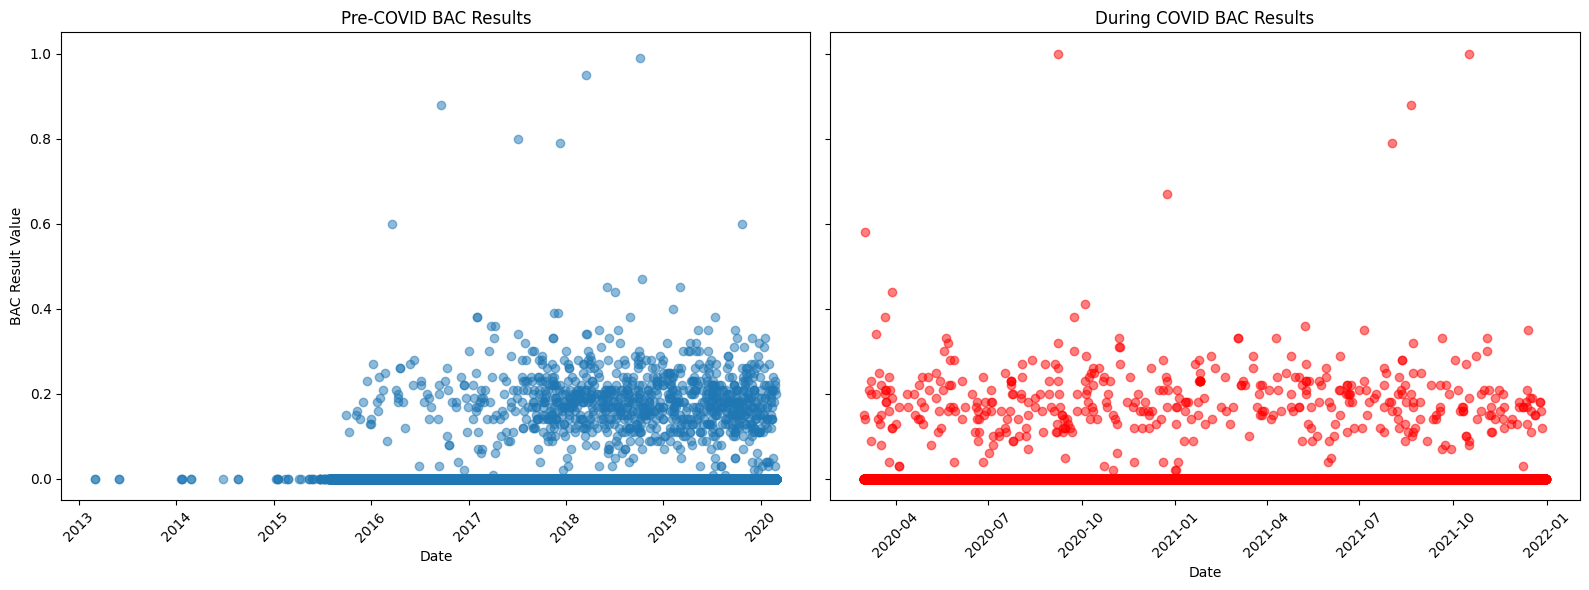

In [9]:
# Scatterplot
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Pre-COVID plot
ax[0].scatter(pre_covid_data['CRASH_DATE'], pre_covid_data['BAC_RESULT VALUE'], alpha=0.5)
ax[0].set_title('Pre-COVID BAC Results')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('BAC Result Value')
ax[0].tick_params('x', labelrotation=45)

# During COVID plot
ax[1].scatter(covid_data['CRASH_DATE'], covid_data['BAC_RESULT VALUE'], color='red', alpha=0.5)
ax[1].set_title('During COVID BAC Results')
ax[1].set_xlabel('Date')
ax[1].tick_params('x', labelrotation=45)

plt.tight_layout()
plt.show()

## Merge and Clean Data sets

In [ ]:
# Merge using 'CRASH_RECORD_ID'
crashes_people_merged = pd.merge(Crashes, People, on=['CRASH_RECORD_ID'], how='left')
merged_data = pd.merge(crashes_people_merged, Vehicles, on=['CRASH_RECORD_ID'],how='left')

In [ ]:
# Drop rows with missing values
full_merged_data = merged_data.dropna()
missing_data_summary_after_drop = full_merged_data.isnull().sum()

## Pre-COVID vs During-COVID

In [ ]:
# Sample 10%
data_sample = full_merged_data.sample(frac=0.1, random_state=42)

# Convert to datetime
data_sample['CRASH_DATE'] = pd.to_datetime(data_sample['CRASH_DATE'])

# Covid started March 2020
covid_start_date = '2020-03-01'

# Split data into pre-COVID and during-COVID
pre_covid_data = data_sample[data_sample['CRASH_DATE'] < covid_start_date]
during_covid_data = data_sample[data_sample['CRASH_DATE'] >= covid_start_date]

# Features
features = ['BAC_RESULT_ENCODED', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE',
            'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
            'ROADWAY_SURFACE_COND', 'AGE', 'SEX']

# Target variable
target = 'INJURY_CLASSIFICATION'

# Split pre-COVID data into features (X) and target (Y)
X_pre_covid = pre_covid_data[features]
y_pre_covid = pre_covid_data[target]

# Split during-COVID data into features (X) and target (Y)
X_during_covid = during_covid_data[features]
y_during_covid = during_covid_data[target]

# Split categorical and numerical features
categorical_features = ['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION',
                        'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'ROADWAY_SURFACE_COND', 'SEX']
numeric_features = ['BAC_RESULT_ENCODED', 'POSTED_SPEED_LIMIT', 'AGE']

In [ ]:
# Preprocessing pipline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),  # Handle missing values for numeric features
        ('cat', OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore'), categorical_features)  # OneHotEncode categorical features
    ])

# Define model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('classifier', RandomForestClassifier(random_state=42))  # Random Forest classifier
])

# Function to train and evaluate the model
def evaluate_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to balance the classes in the training data
    smote = SMOTE(random_state=42)

    # Preprocess and apply SMOTE
    X_train_preprocessed = pipeline.named_steps['preprocessor'].fit_transform(X_train)
    X_test_preprocessed = pipeline.named_steps['preprocessor'].transform(X_test)

    X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

    # Train the model on the SMOTE-resampled data
    pipeline.named_steps['classifier'].fit(X_train_smote, y_train_smote)

    # Make predictions on the test data
    y_pred = pipeline.named_steps['classifier'].predict(X_test_preprocessed)

    # Print evaluation metrics
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Evaluate the model for pre-COVID data
print("Pre-COVID Evaluation:")
evaluate_model(X_pre_covid, y_pre_covid)

# Evaluate the model for during-COVID data
print("During COVID Evaluation:")
evaluate_model(X_during_covid, y_during_covid)




Pre-COVID Evaluation:
Classification Report:
                           precision    recall  f1-score   support

                   FATAL       0.00      0.00      0.00        13
   INCAPACITATING INJURY       0.10      0.10      0.10       194
 NO INDICATION OF INJURY       0.91      0.93      0.92     17652
NONINCAPACITATING INJURY       0.14      0.11      0.13       985
   REPORTED, NOT EVIDENT       0.10      0.09      0.09       703

                accuracy                           0.85     19547
               macro avg       0.25      0.25      0.25     19547
            weighted avg       0.84      0.85      0.84     19547

Confusion Matrix:
 [[    0     0    11     2     0]
 [    0    19   156    12     7]
 [    5   153 16393   618   483]
 [    0    16   812   112    45]
 [    0    11   588    44    60]]
During COVID Evaluation:
Classification Report:
                           precision    recall  f1-score   support

                   FATAL       0.05      0.07      0.06 